# NEW DATA => Radial Profiles with COS-Holes Data
## Ben: May 12-14 ish; Nicole: June 5th 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [2]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [3]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')
cosholes_df

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.002230,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.003300,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.650000,0.050000,0.000,0.000,0.000,0.000,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.500000,0.050000,0.000,0.000,0.000,0.000,1,0
4,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.000000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
5,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.000510,13.855000,0.052000,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.000810,13.652000,0.103000,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.001090,13.946000,0.044000,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.004420,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.002750,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1


In [4]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0


In [5]:
#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
4,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1


In [6]:
#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
com_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403,0.099,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697,0.074,80.715,17.306,-9.444,12.162,1,1
5,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.00051,13.855,0.052,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.00081,13.652,0.103,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.00109,13.946,0.044,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012,0.076,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211,0.053,54.100,7.973,18.210,5.687,1,1


In [7]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [8]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

In [9]:
#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)

In [10]:
#EAGLE

df_r_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH50_97_2bins.MS100_110.5.0_7.375.dat",sep=" ")
df_r_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH50_97_2bins.MS100_110.7.375_9.75.dat",sep=" ")

In [11]:
# TNG 

df_r_new_lowtng = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_TNG.halo.list.CIV_median.MBH60_104_2bins.MS100_110.6.05_8.225.dat",sep=" ")
df_r_new_hightng = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_TNG.halo.list.CIV_median.MBH60_104_2bins.MS100_110.8.225_10.4.dat",sep=" ")

In [12]:
#New Data from Nicole (June 5th 2023) for R25

r25_rr = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_RoverRvir_new.txt', 
                       sep=" ", header=None, names =['Rproj/Rvir'])
r25_r = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_Rkpc.txt', 
                       sep=" ", header=None, names =['Rproj'])

#High MBH Things 
hmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
hmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_16percentile_new.txt.txt', 
                       sep=" ", header=None, names =['16per'])
hmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_84percentile_new.txt.txt', 
                       sep=" ", header=None, names =['84per'])

#Low MBH Things 
#High MBH Things 
lmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
lmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])
lmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

#Galaxy Histogram info 
r25_mhalo = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mhalo.txt', 
                       sep=" ", header=None, names =['Mhalo'])

r25_mbh = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Msmbh.txt', 
                       sep=" ", header=None, names =['Mbh'])

r25_mstar = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mstar.txt', 
                       sep=" ", header=None, names =['Mhalo'])

#All the MBH together
all_r25_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])

all_r25_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])


all_r25_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

## Galaxy Property Histograms 

In [13]:
#reading in values from EAGLE 
es= pd.read_table("/Users/samgarza/Downloads/EAGLEstats.z0.0.cat", delim_whitespace=True) #, 
                # names =['ID', 'M200', 'MStar', 'lg_SSFR', 'MBH', 'fgas', 'Kappa', 'j'])
es.set_axis(['ID', 'M200', 'MStar', 'lg_SSFR', 'MBH', 'fgas', 'Kappa', 'j', 'ick'], axis="columns", inplace=True)
es = es.drop('ick', axis=1)
#es

In [14]:
#getting only the values for the cuts we have made 
ES = es.loc[(es['MStar'] >= 10) & (es['MStar'] <= 11)]
ES = ES.loc[(ES['MBH'] >= 5.0) & (ES['MBH'] <= 10)]
ES = ES.loc[(es['M200'] >= 11.2)]
#ES

In [15]:
#getting values for TNG
ts= pd.read_table("/Users/samgarza/Downloads/TNGstats.z0.0.cat", delim_whitespace=True) #, 
                # names =['ID', 'M200', 'MStar', 'lg_SSFR', 'MBH', 'fgas', 'Kappa', 'j'])
ts.set_axis(['ID', 'M200', 'MStar', 'lg_SSFR', 'MBH', 'fgas', 'Kappa', 'j', 'ick'], axis="columns", inplace=True)
ts = ts.drop('ick', axis=1)
#ts

In [16]:
#getting the values that we need based on the cuts that we made 
#TS = ts.loc[(ts['M200'] >= 12.0) & (ts['M200'] <= 12.5)]
TS = ts.loc[(ts['MBH'] >= 5.0) & (ts['MBH'] <= 10)]
TS = TS.loc[(TS['MStar'] >= 10) & (TS['MStar'] <= 11)]
TS = TS.loc[(TS['M200'] >= 11.2)]
#TS

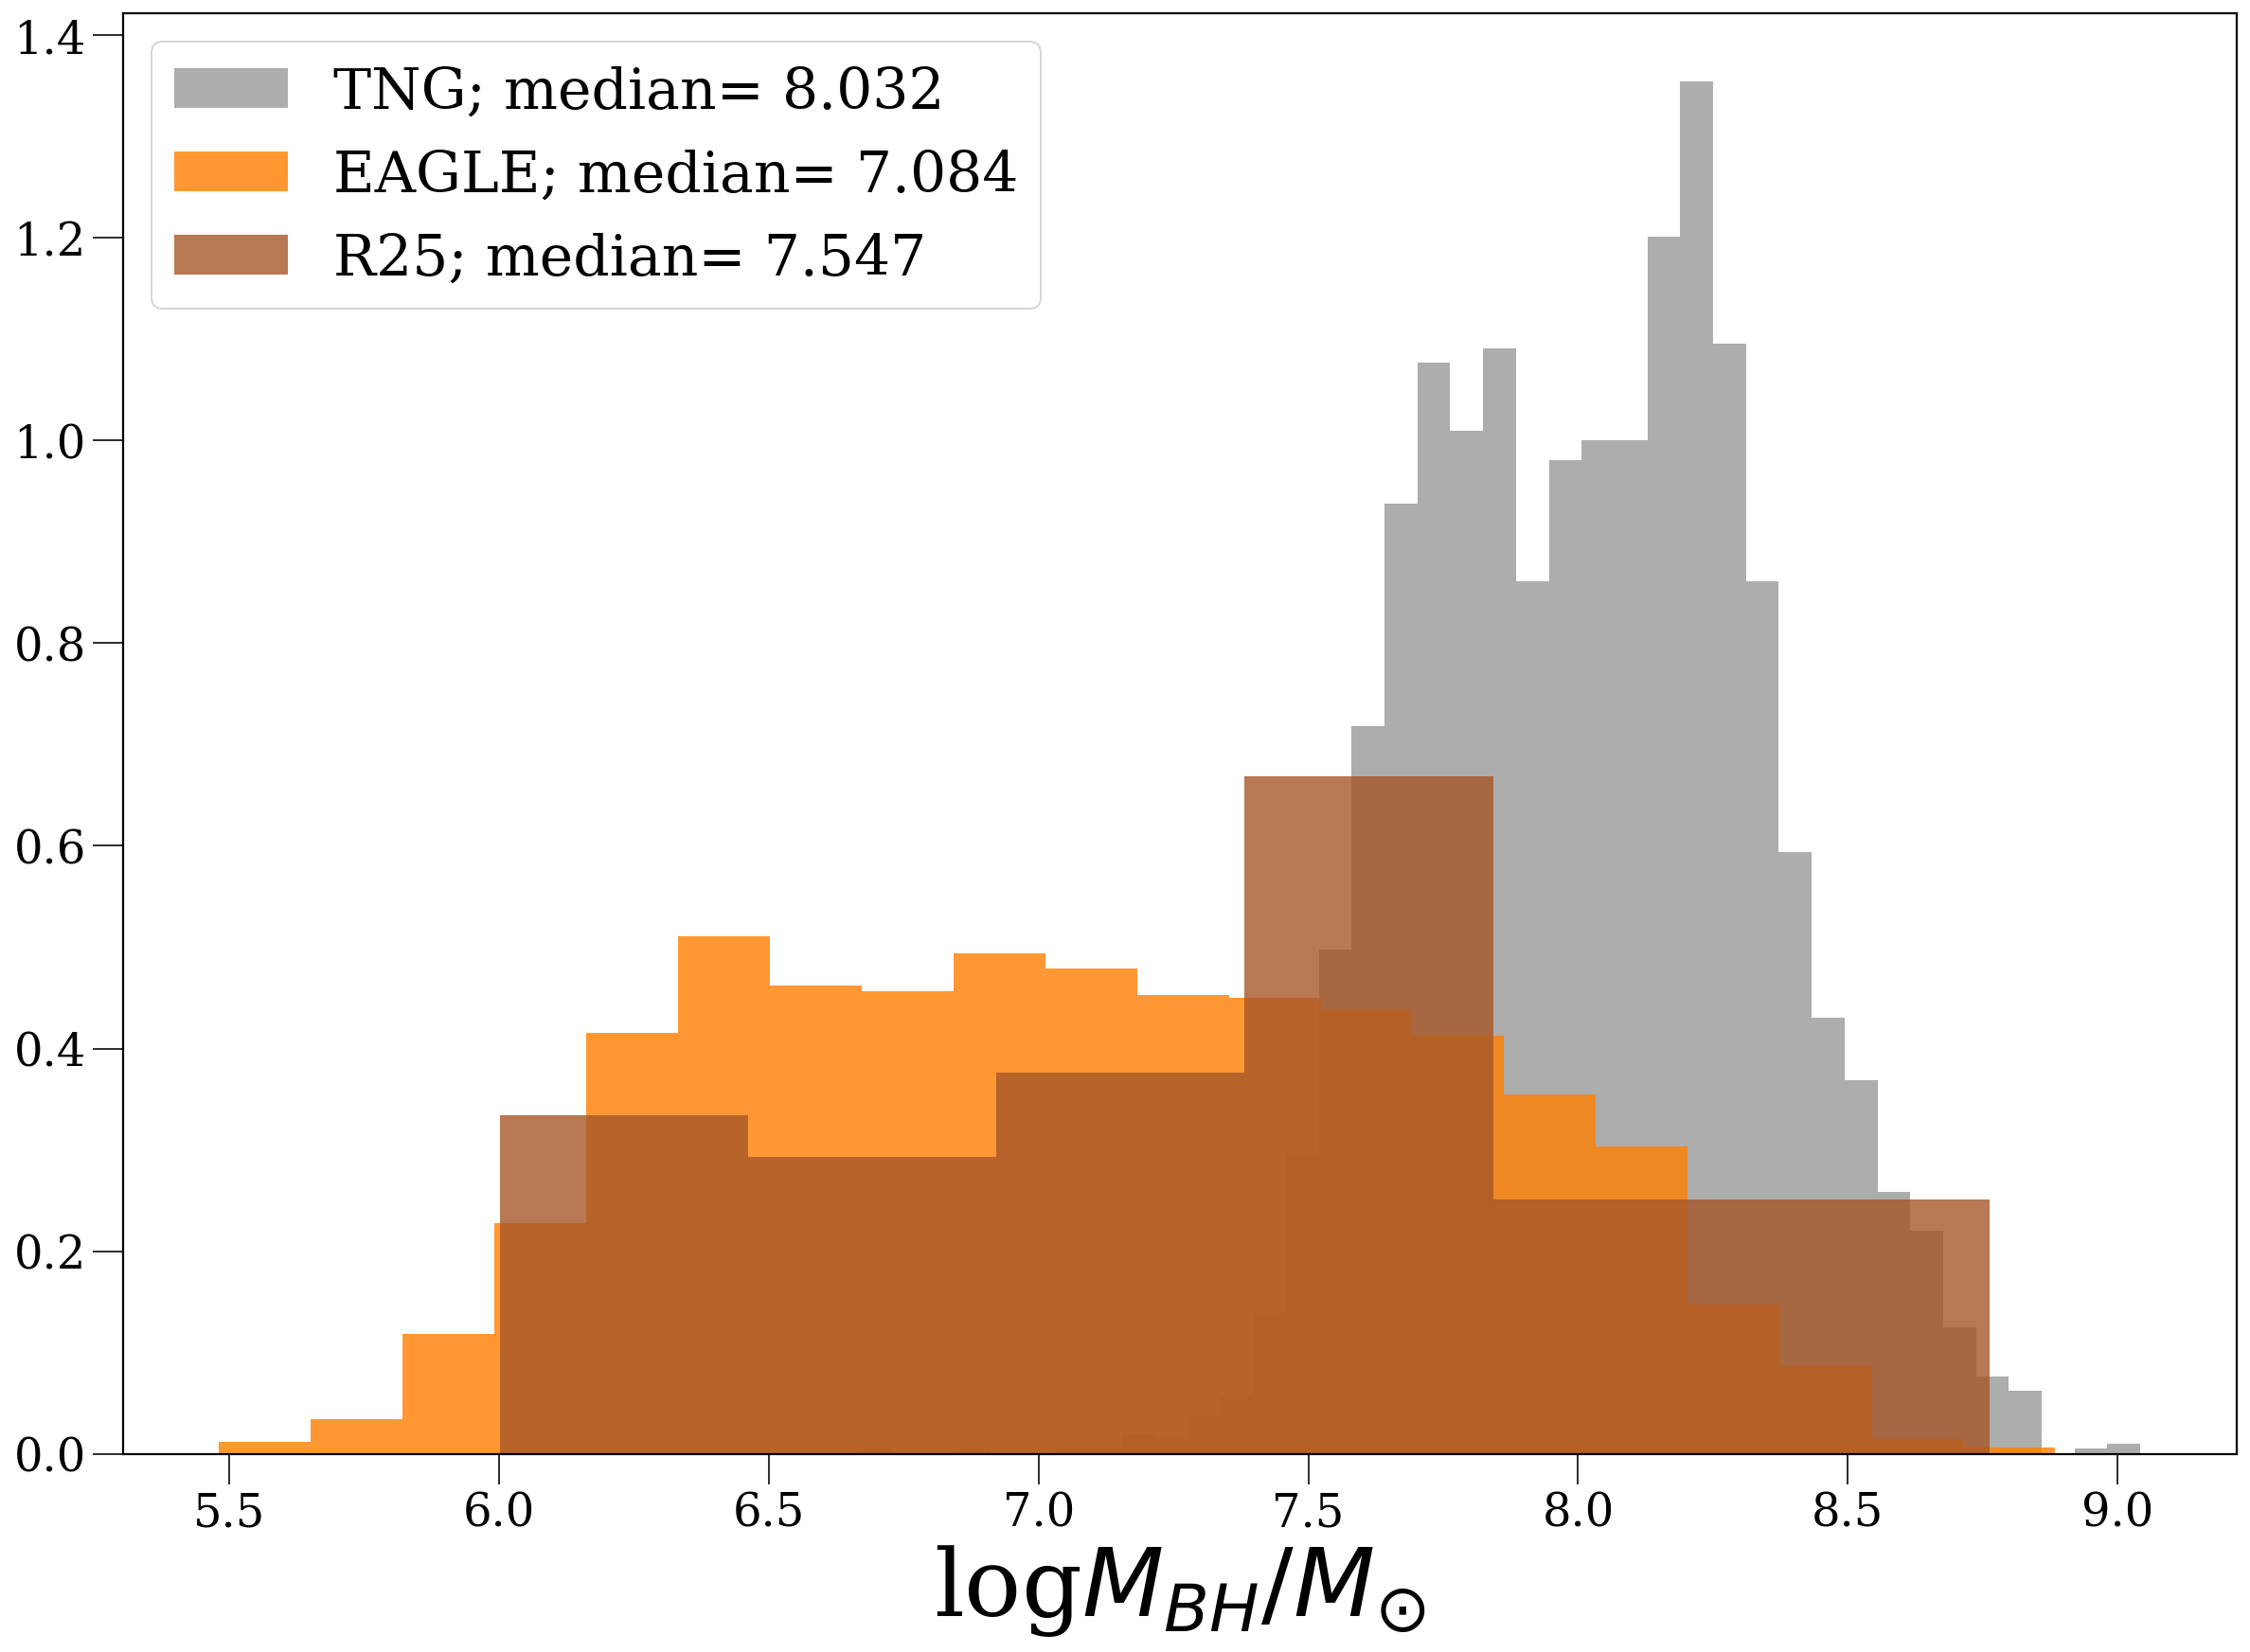

In [17]:
plt.hist(TS['MBH'], bins='fd', alpha = 0.8, color = CB_color_cycle[6], label = f'TNG; median= {np.median(TS["MBH"])}', density=True)
plt.hist(ES['MBH'], bins='fd', alpha = 0.8, color = CB_color_cycle[1], label = f'EAGLE; median= {np.median(ES["MBH"])}', density=True)
plt.hist(np.log10(r25_mbh), bins='fd', alpha = 0.8, color = CB_color_cycle[4], 
         label = f'R25; median= {np.round(np.median(np.log10(r25_mbh)),3)}', density=True)
plt.legend(fontsize=30)
plt.xlabel(r'log$M_{BH}/M_{\odot}$', fontsize=50)
#plt.savefig('Figures/hist_mbh.png')
plt.show()

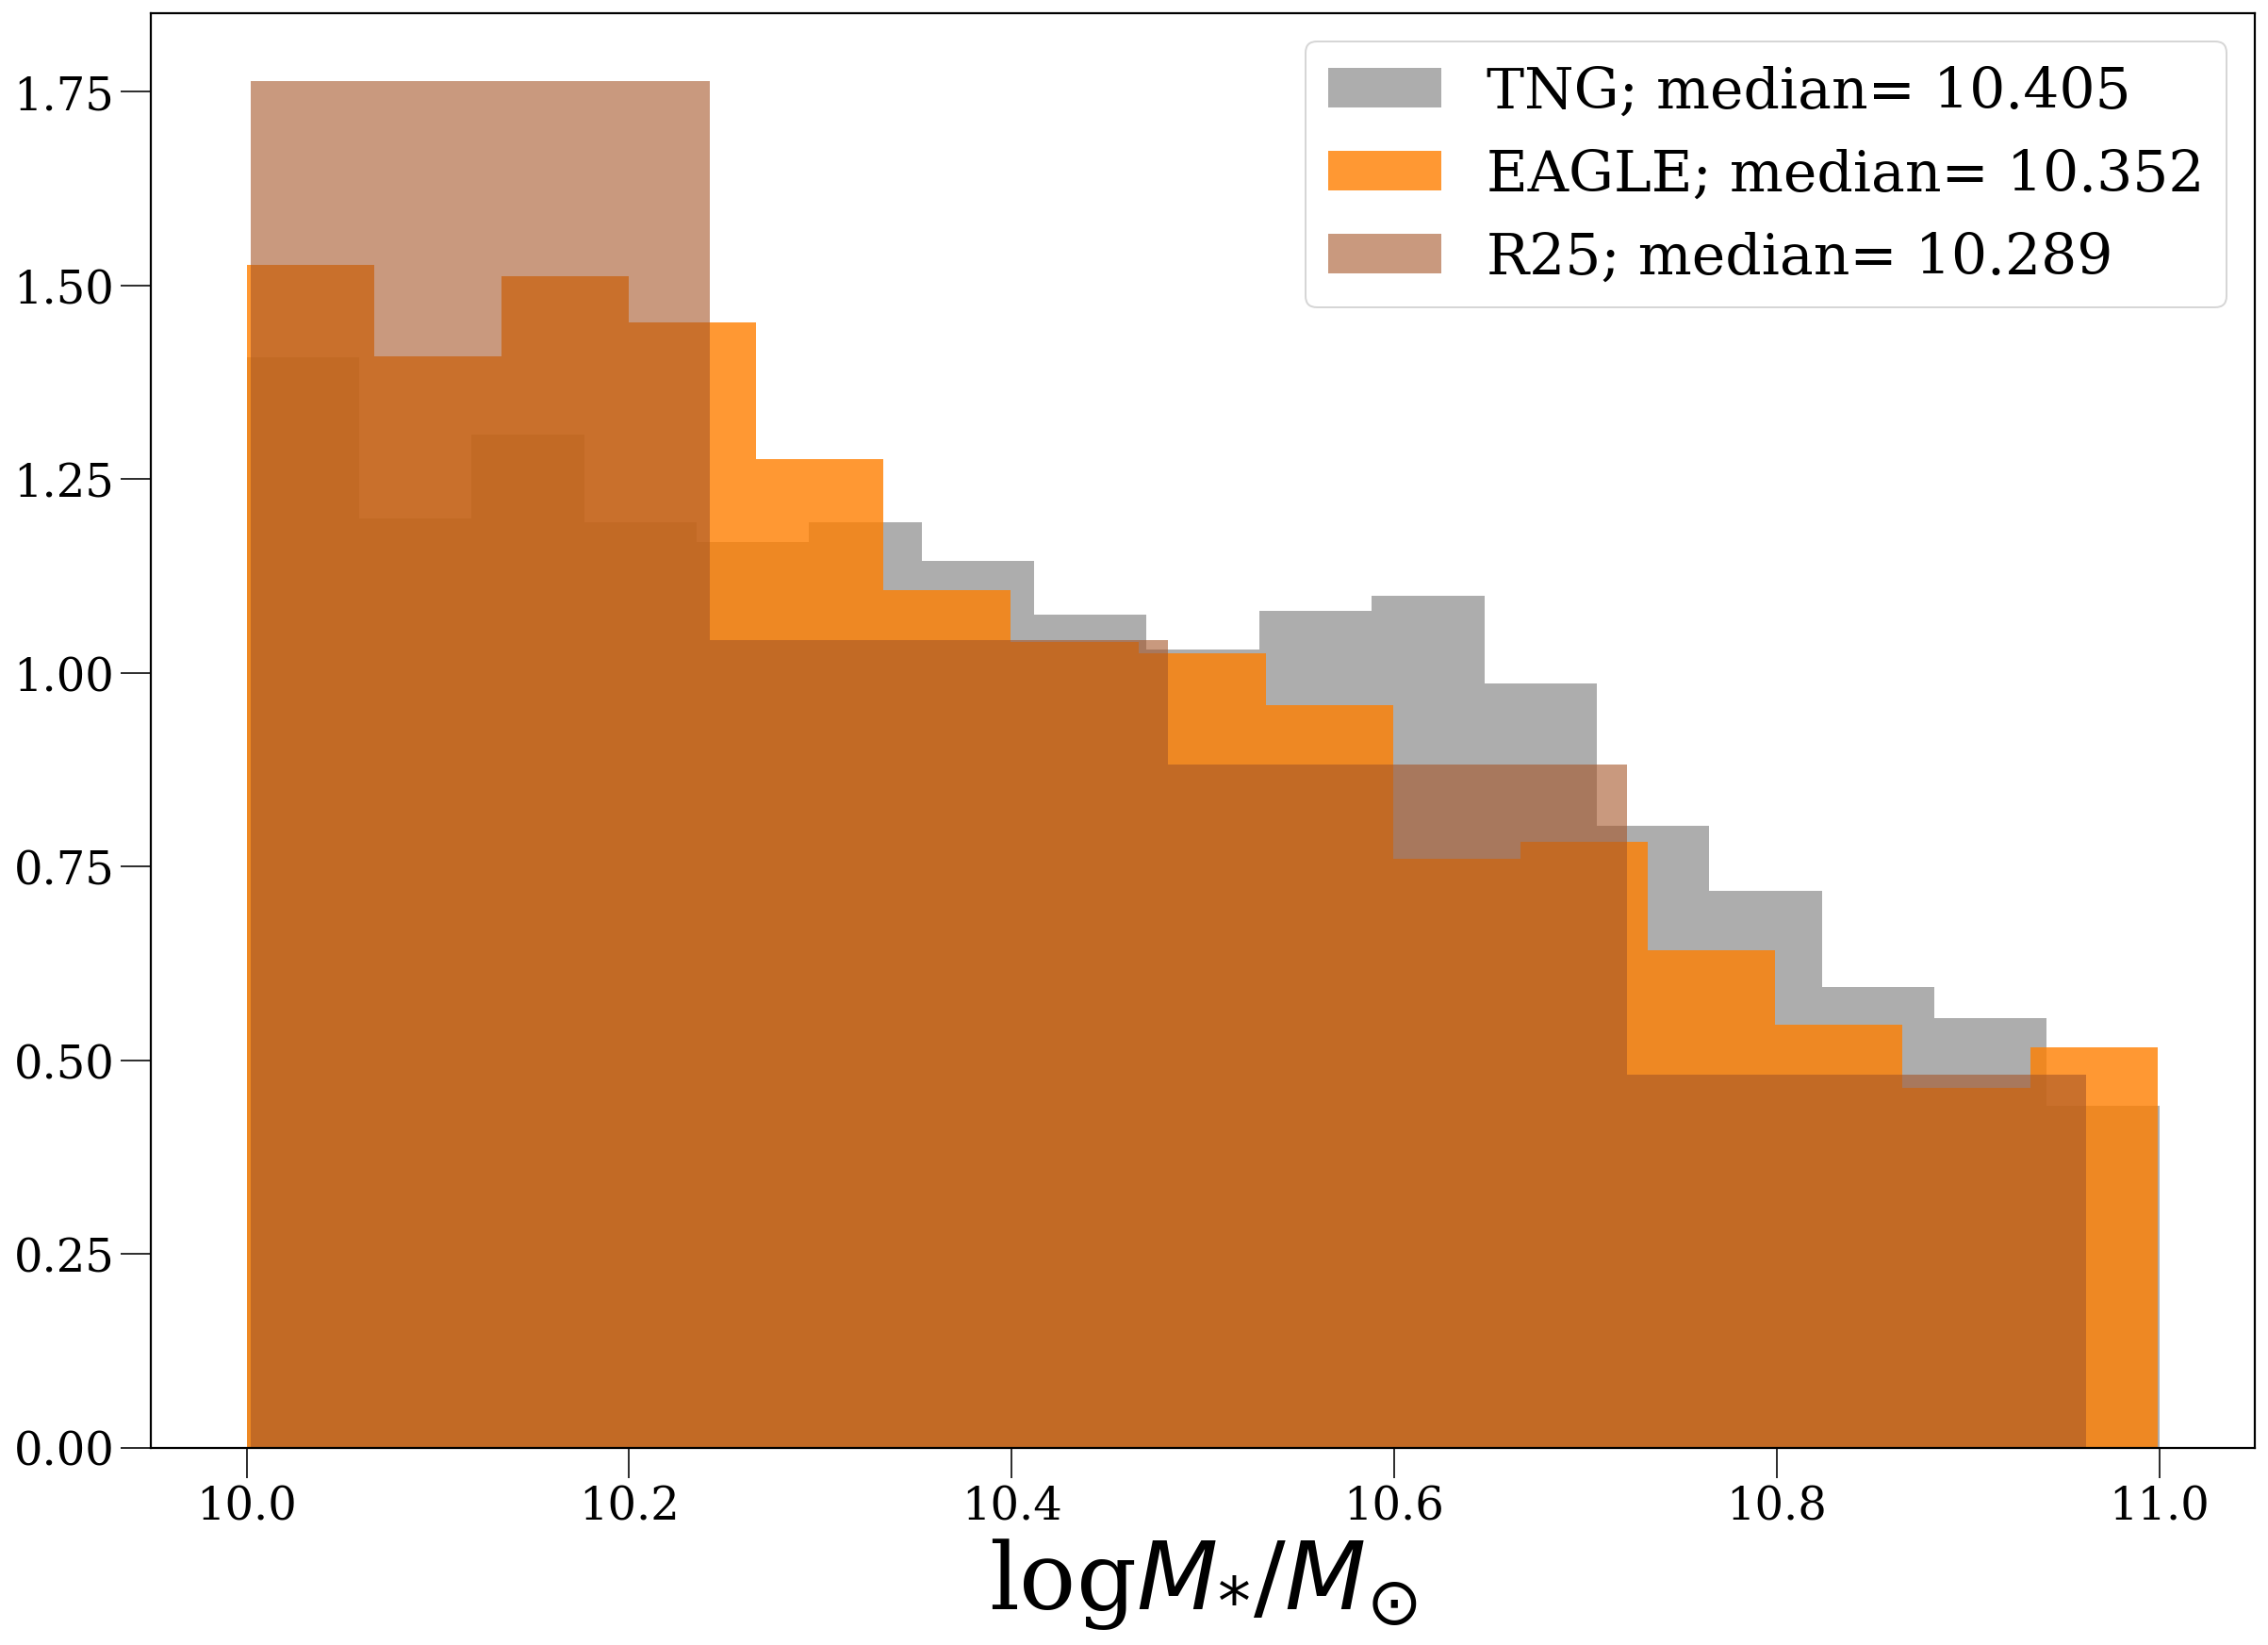

In [18]:
plt.hist(TS['MStar'], bins='fd', alpha = 0.8, color = CB_color_cycle[6], label = f'TNG; median= {np.median(TS["MStar"])}', density=True)
plt.hist(ES['MStar'], bins='fd', alpha = 0.8, color = CB_color_cycle[1], label = f'EAGLE; median= {np.median(ES["MStar"])}', density=True)
plt.hist(np.log10(r25_mstar), bins='fd', alpha = 0.6, color = CB_color_cycle[4], 
         label = f'R25; median= {np.round(np.median(np.log10(r25_mstar)),3)}', density=True)
plt.legend(fontsize=30)
plt.xlabel(r'log$M_{*}/M_{\odot}$', fontsize=50)
#plt.savefig('Figures/hist_mstellar.png')
plt.show()

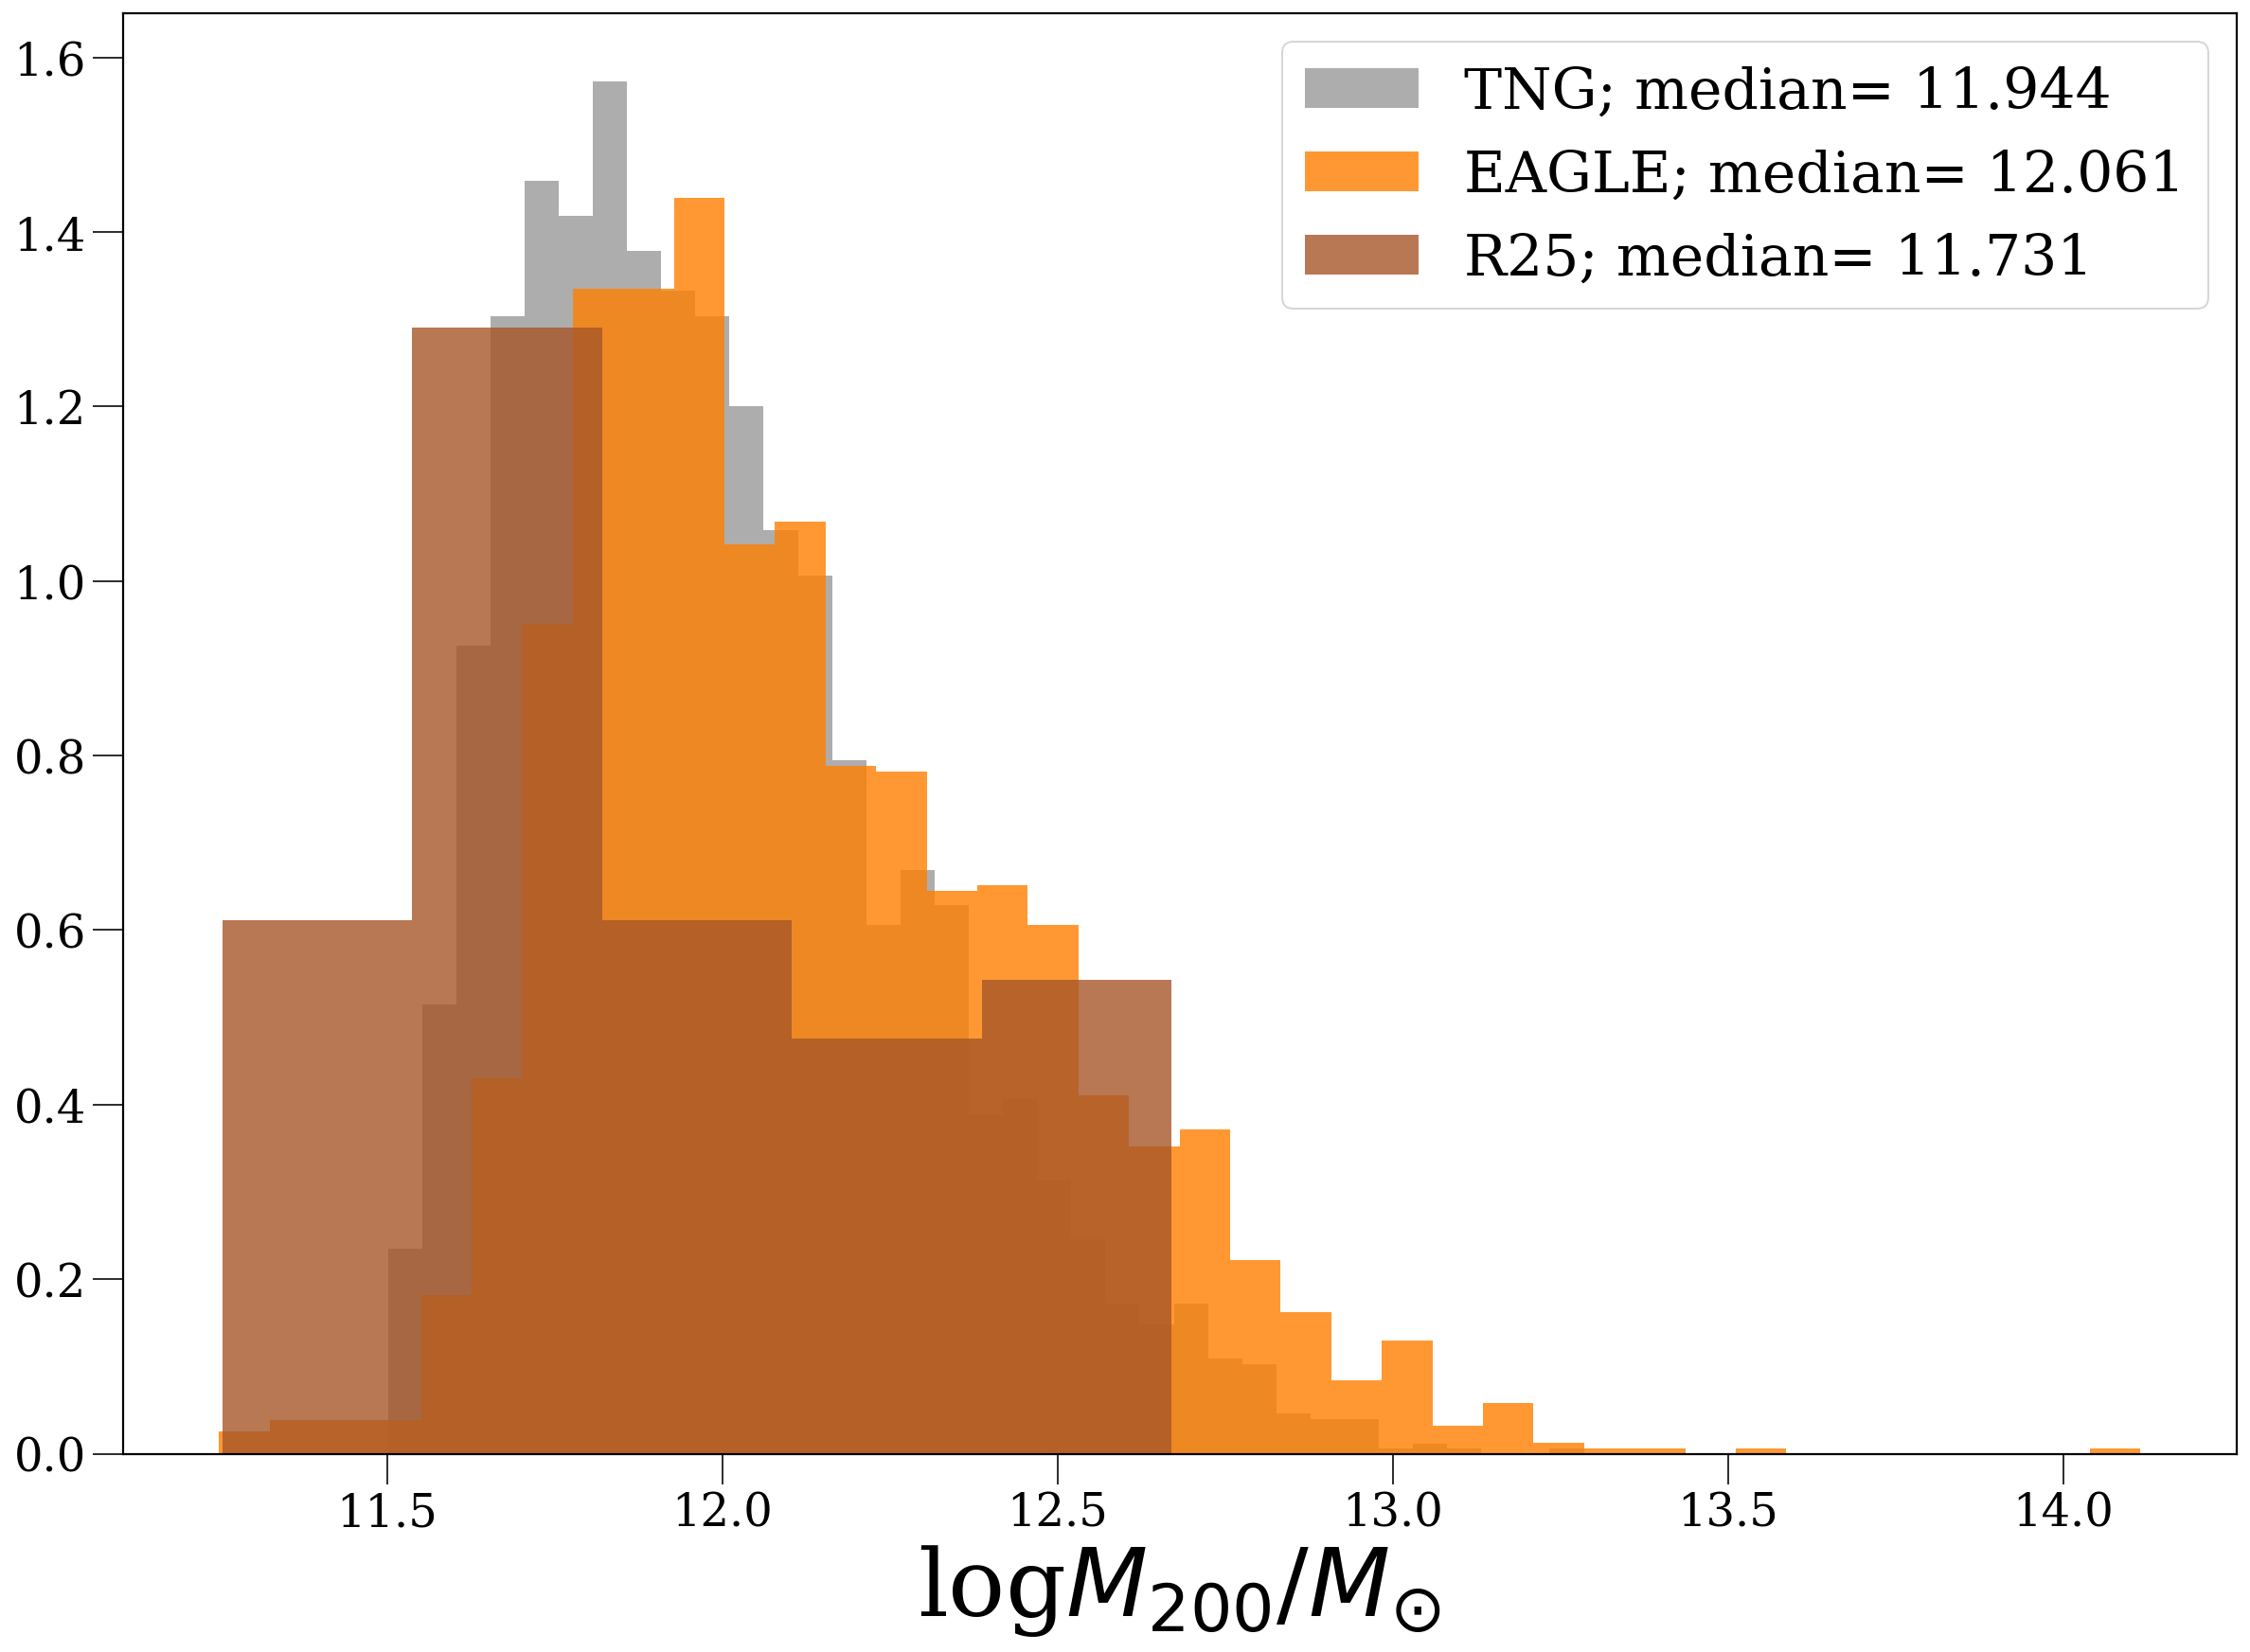

In [19]:
plt.hist(TS['M200'], bins='fd', alpha = 0.8, color = CB_color_cycle[6], label = f'TNG; median= {np.median(TS["M200"])}', density=True)
plt.hist(ES['M200'], bins='fd', alpha = 0.8, color = CB_color_cycle[1], 
         label = f'EAGLE; median= {np.round(np.median(ES["M200"]),3)}', density=True)
plt.hist(np.log10(r25_mhalo), bins='fd', alpha = 0.8, color = CB_color_cycle[4], 
         label = f'R25; median= {np.round(np.median(np.log10(r25_mhalo)),3)}', density=True)
plt.legend(fontsize=30)
plt.xlabel(r'log$M_{200}/M_{\odot}$', fontsize=50)
#plt.savefig('Figures/hist_mstellar.png')
plt.show()

## Radial Profiles for Sims 

What I still need:
- EAGLE split RR
- TNG split RR

<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6107/3029950621.py:10: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_high['#R(kpc)'], df_r_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 7.4-9.8; n=710')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6107/3029950621.py:12: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_low['#R(kpc)'], df_r_new_low['median'], color = CB_color_cycle[2], lw = 5, label =

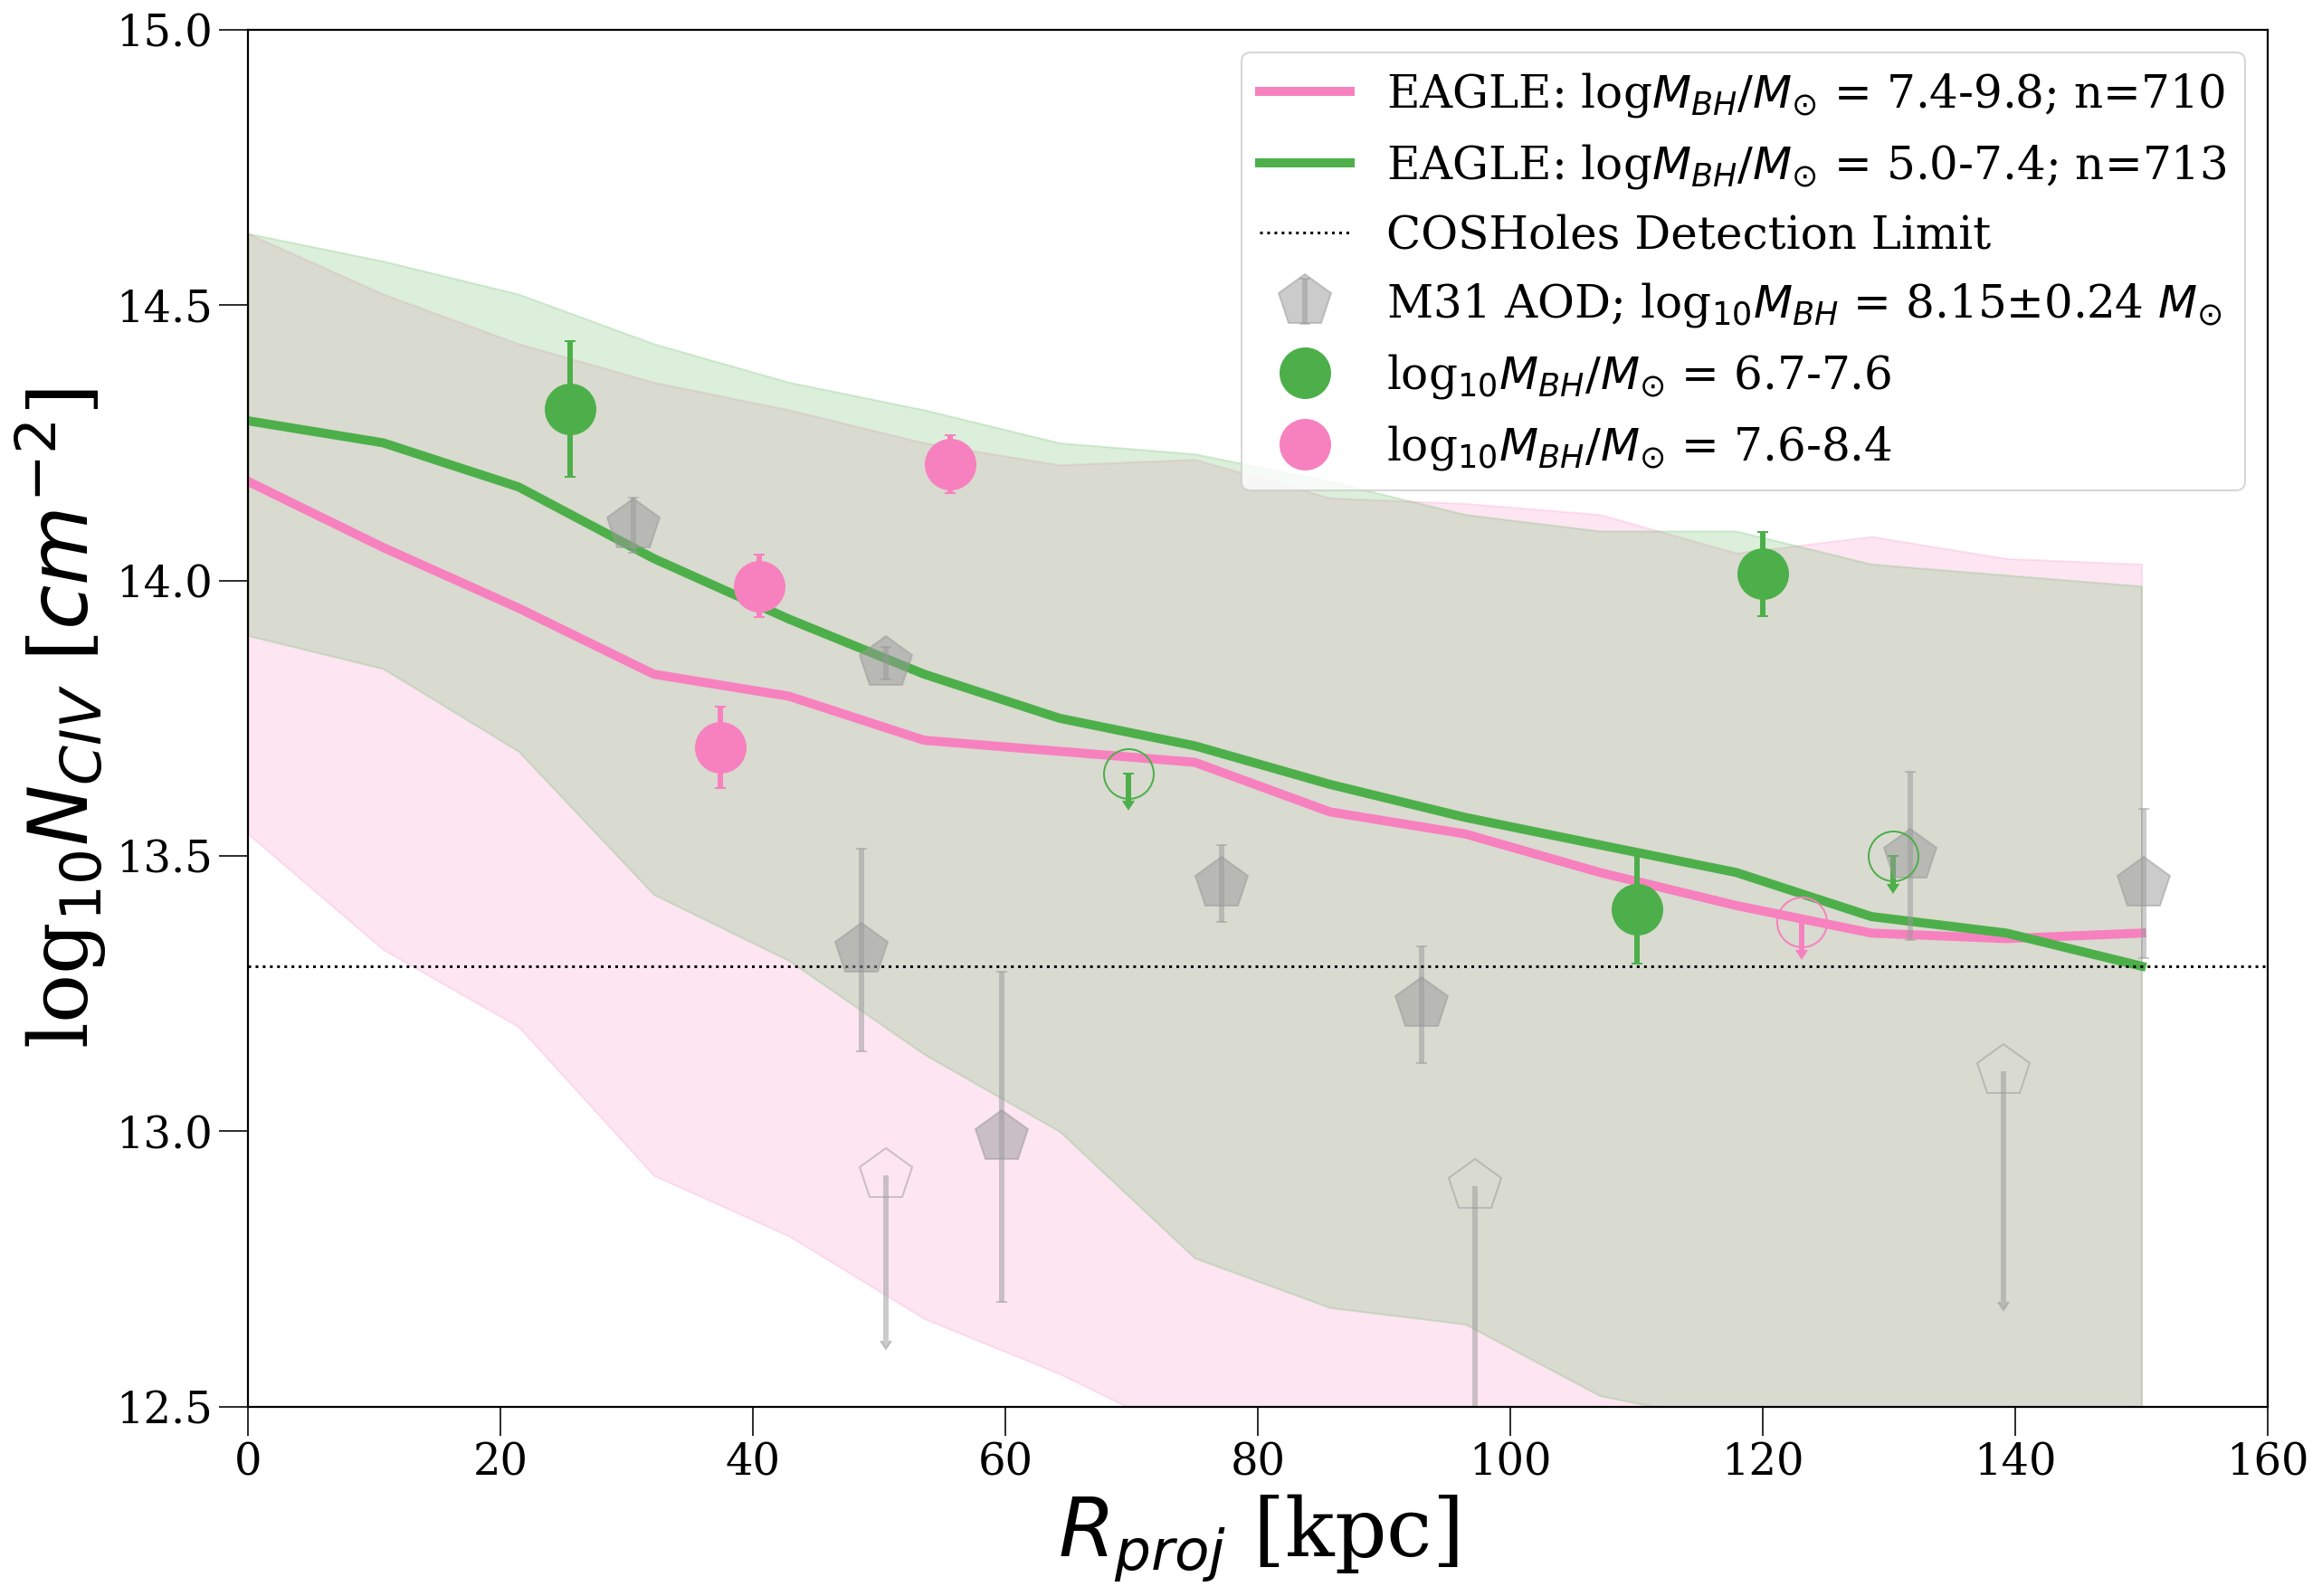

In [20]:
#Plotting NCIV vs Rproj for EAGLE 
    
fig, ax = plt.subplots()

########################################################

#EAGLE Simulational Data

plt.fill_between(df_r_new_high['#R(kpc)'], df_r_new_high['16percentile'], df_r_new_high['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(df_r_new_high['#R(kpc)'], df_r_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 7.4-9.8; n=710')
plt.fill_between(df_r_new_low['#R(kpc)'], df_r_new_low['16percentile'], df_r_new_low['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(df_r_new_low['#R(kpc)'], df_r_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 5.0-7.4; n=713')

   
########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 , used lightgrey before 

##### M31 Detections (Sums) 
plt.errorbar (amiga_2_det_sum['Rad'], amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha = 0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_2_up_sum['Rad'], amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}/M_{\odot}$ = 6.7-7.6", 
                                r"log$_{10}M_{BH}/M_{\odot}$ = 7.6-8.4"]):
    
    ax.errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=25)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 160)
#plt.savefig('Figures/nciv_eaglenew_vs_r.png')
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6107/674266757.py:10: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_hightng['#R(kpc)'], df_r_new_hightng['median'], color = CB_color_cycle[3], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 8.2-10.4; n=1054')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6107/674266757.py:12: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['median'], color = CB_color_cycle[2], lw = 

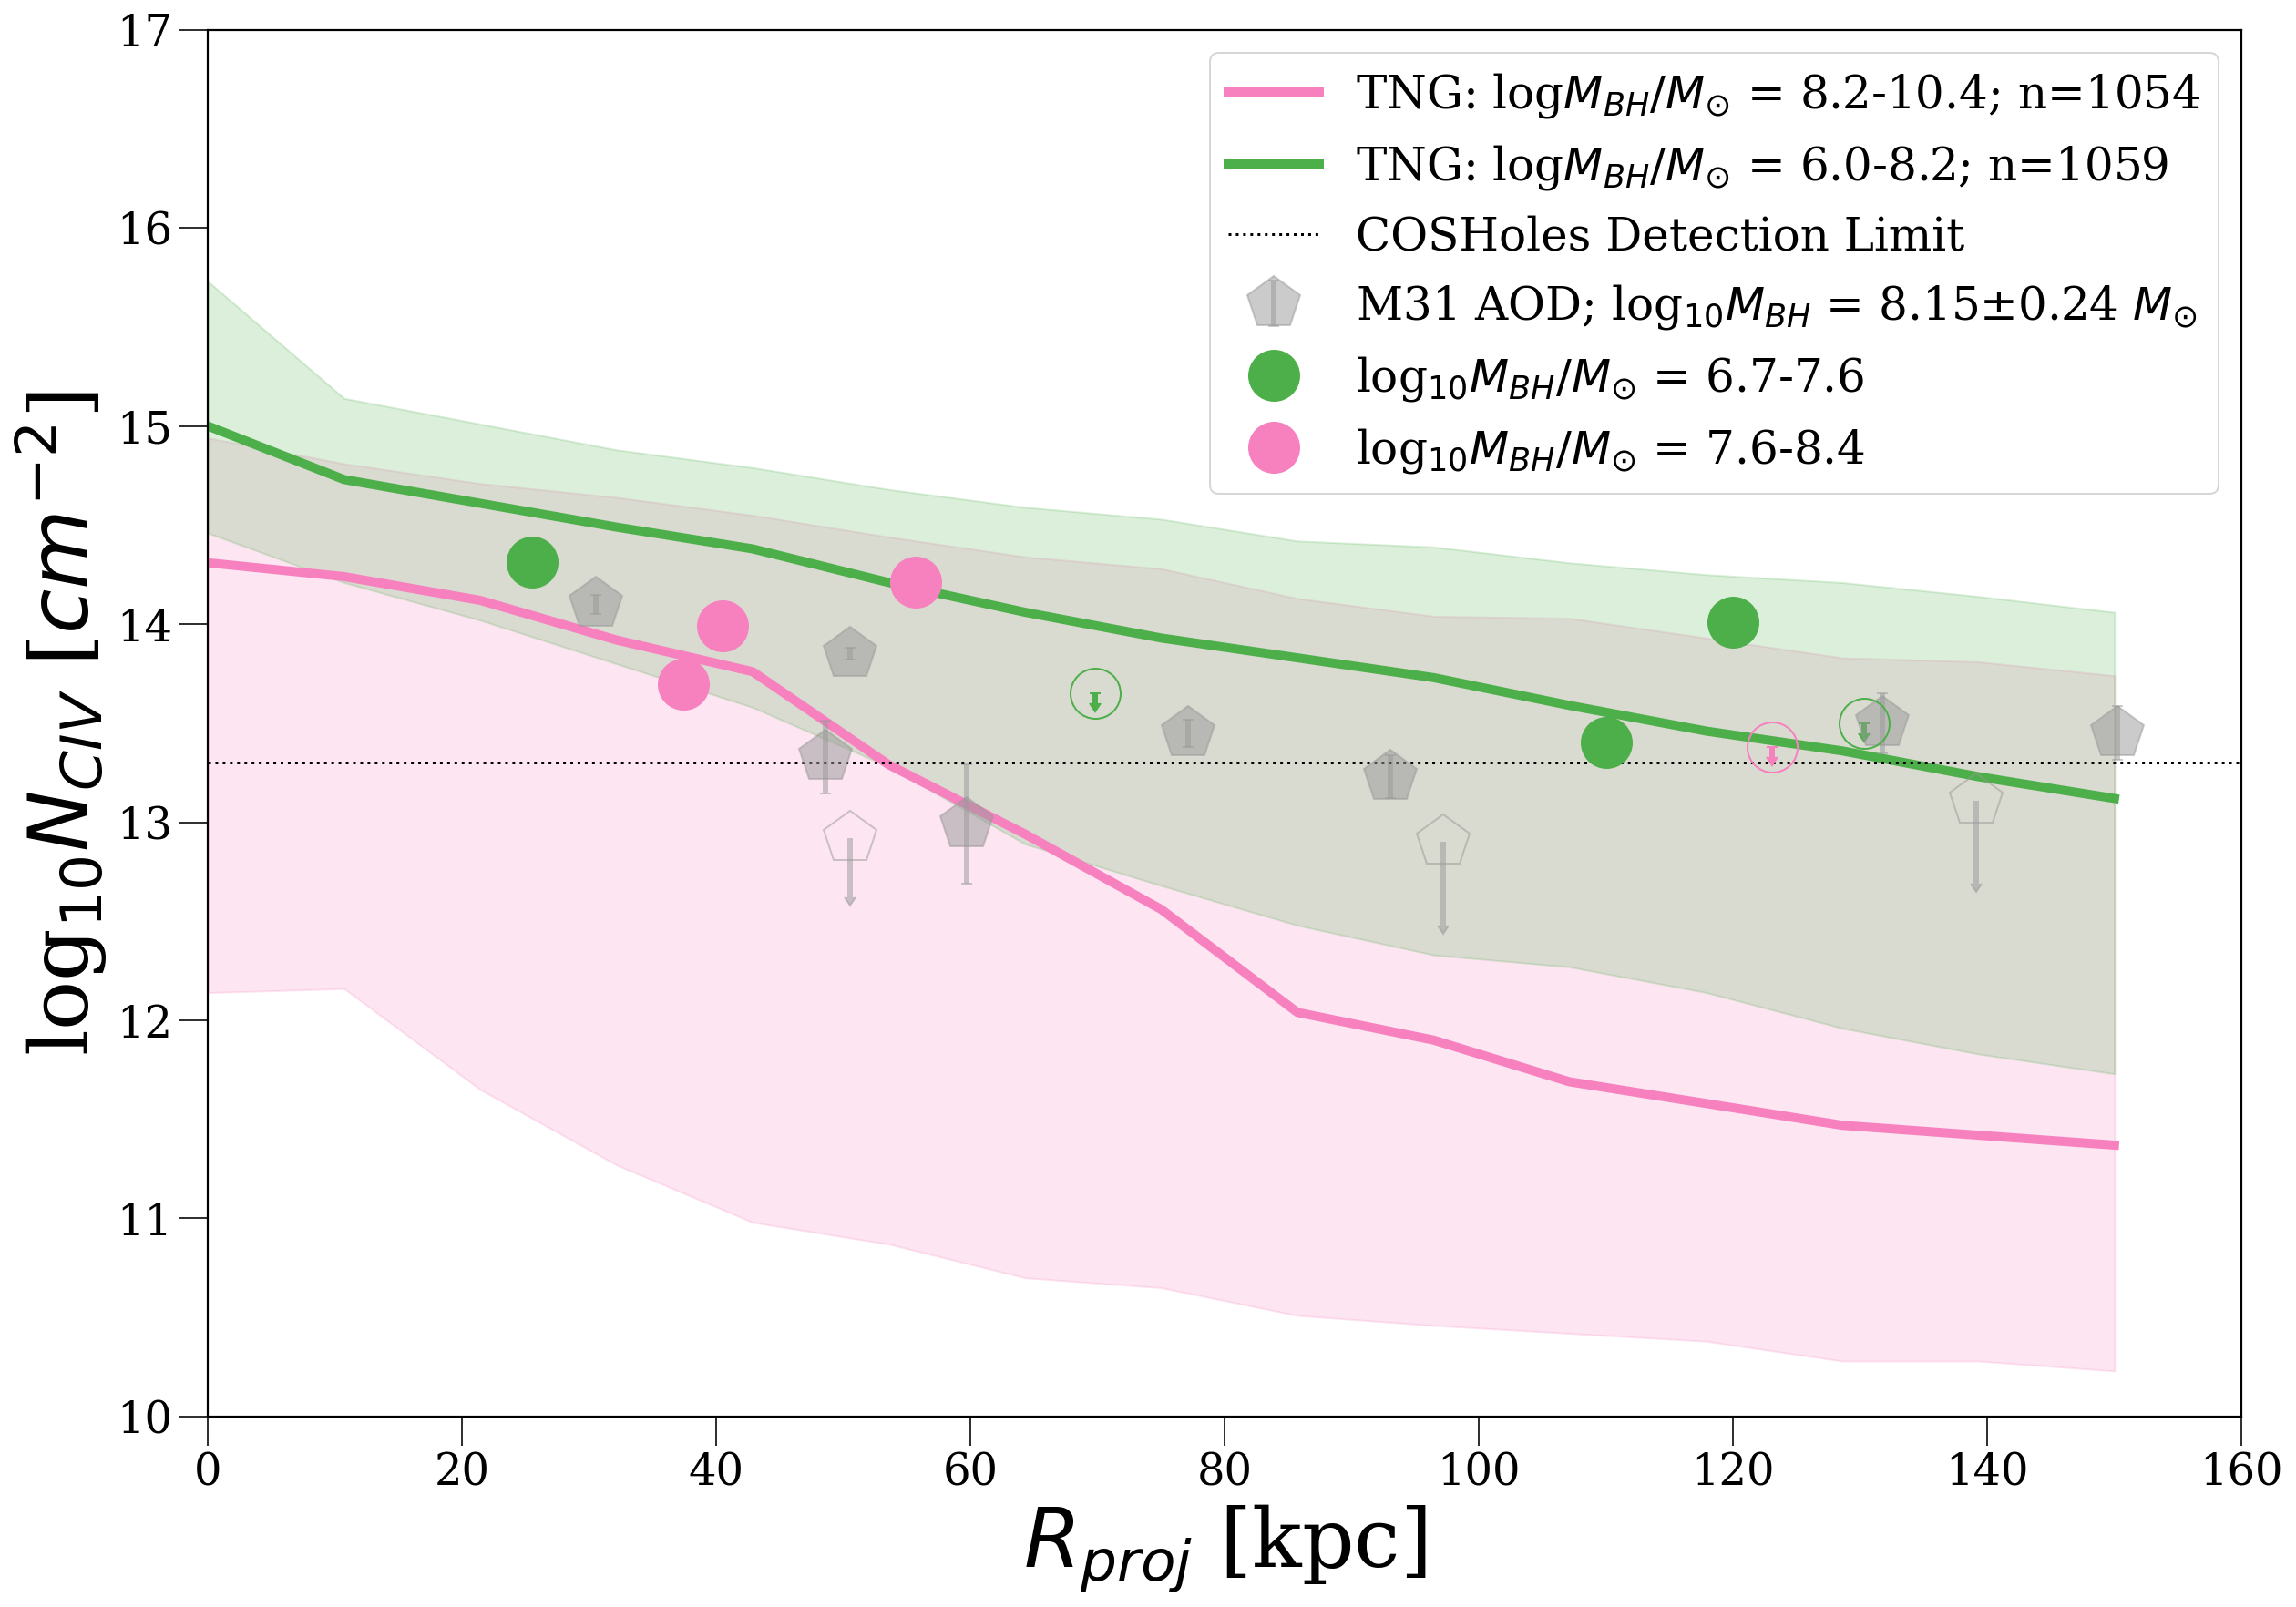

In [21]:
#Plotting NCIV vs Rproj for TNG 
    
fig, ax = plt.subplots()

########################################################

#TNG Simulational Data

plt.fill_between(df_r_new_hightng['#R(kpc)'], df_r_new_hightng['16percentile'], df_r_new_hightng['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(df_r_new_hightng['#R(kpc)'], df_r_new_hightng['median'], color = CB_color_cycle[3], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 8.2-10.4; n=1054')
plt.fill_between(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['16percentile'], df_r_new_lowtng['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['median'], color = CB_color_cycle[2], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 6.0-8.2; n=1059')

   
########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 , used lightgrey before 

##### M31 Detections (Sums) 
plt.errorbar (amiga_2_det_sum['Rad'], amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha = 0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_2_up_sum['Rad'], amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}/M_{\odot}$ = 6.7-7.6", 
                                r"log$_{10}M_{BH}/M_{\odot}$ = 7.6-8.4"]):
    
    ax.errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=25)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(10, 17)
ax.set_xlim(0, 160)
#plt.savefig('Figures/nciv_tng_vs_r.png')
plt.show()

<>:11: DeprecationWarning: invalid escape sequence \o
<>:14: DeprecationWarning: invalid escape sequence \l
<>:23: DeprecationWarning: invalid escape sequence \p
<>:11: DeprecationWarning: invalid escape sequence \o
<>:14: DeprecationWarning: invalid escape sequence \l
<>:23: DeprecationWarning: invalid escape sequence \p
<>:11: DeprecationWarning: invalid escape sequence \o
<>:14: DeprecationWarning: invalid escape sequence \l
<>:23: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6107/1444238451.py:11: DeprecationWarning: invalid escape sequence \o
  label = 'R25: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6107/1444238451.py:14: DeprecationWarning: invalid escape sequence \l
  label = 'R25: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6107/1444238451.py:23: DeprecationWarning: invalid escape sequence \p
  alpha =0.5, ma

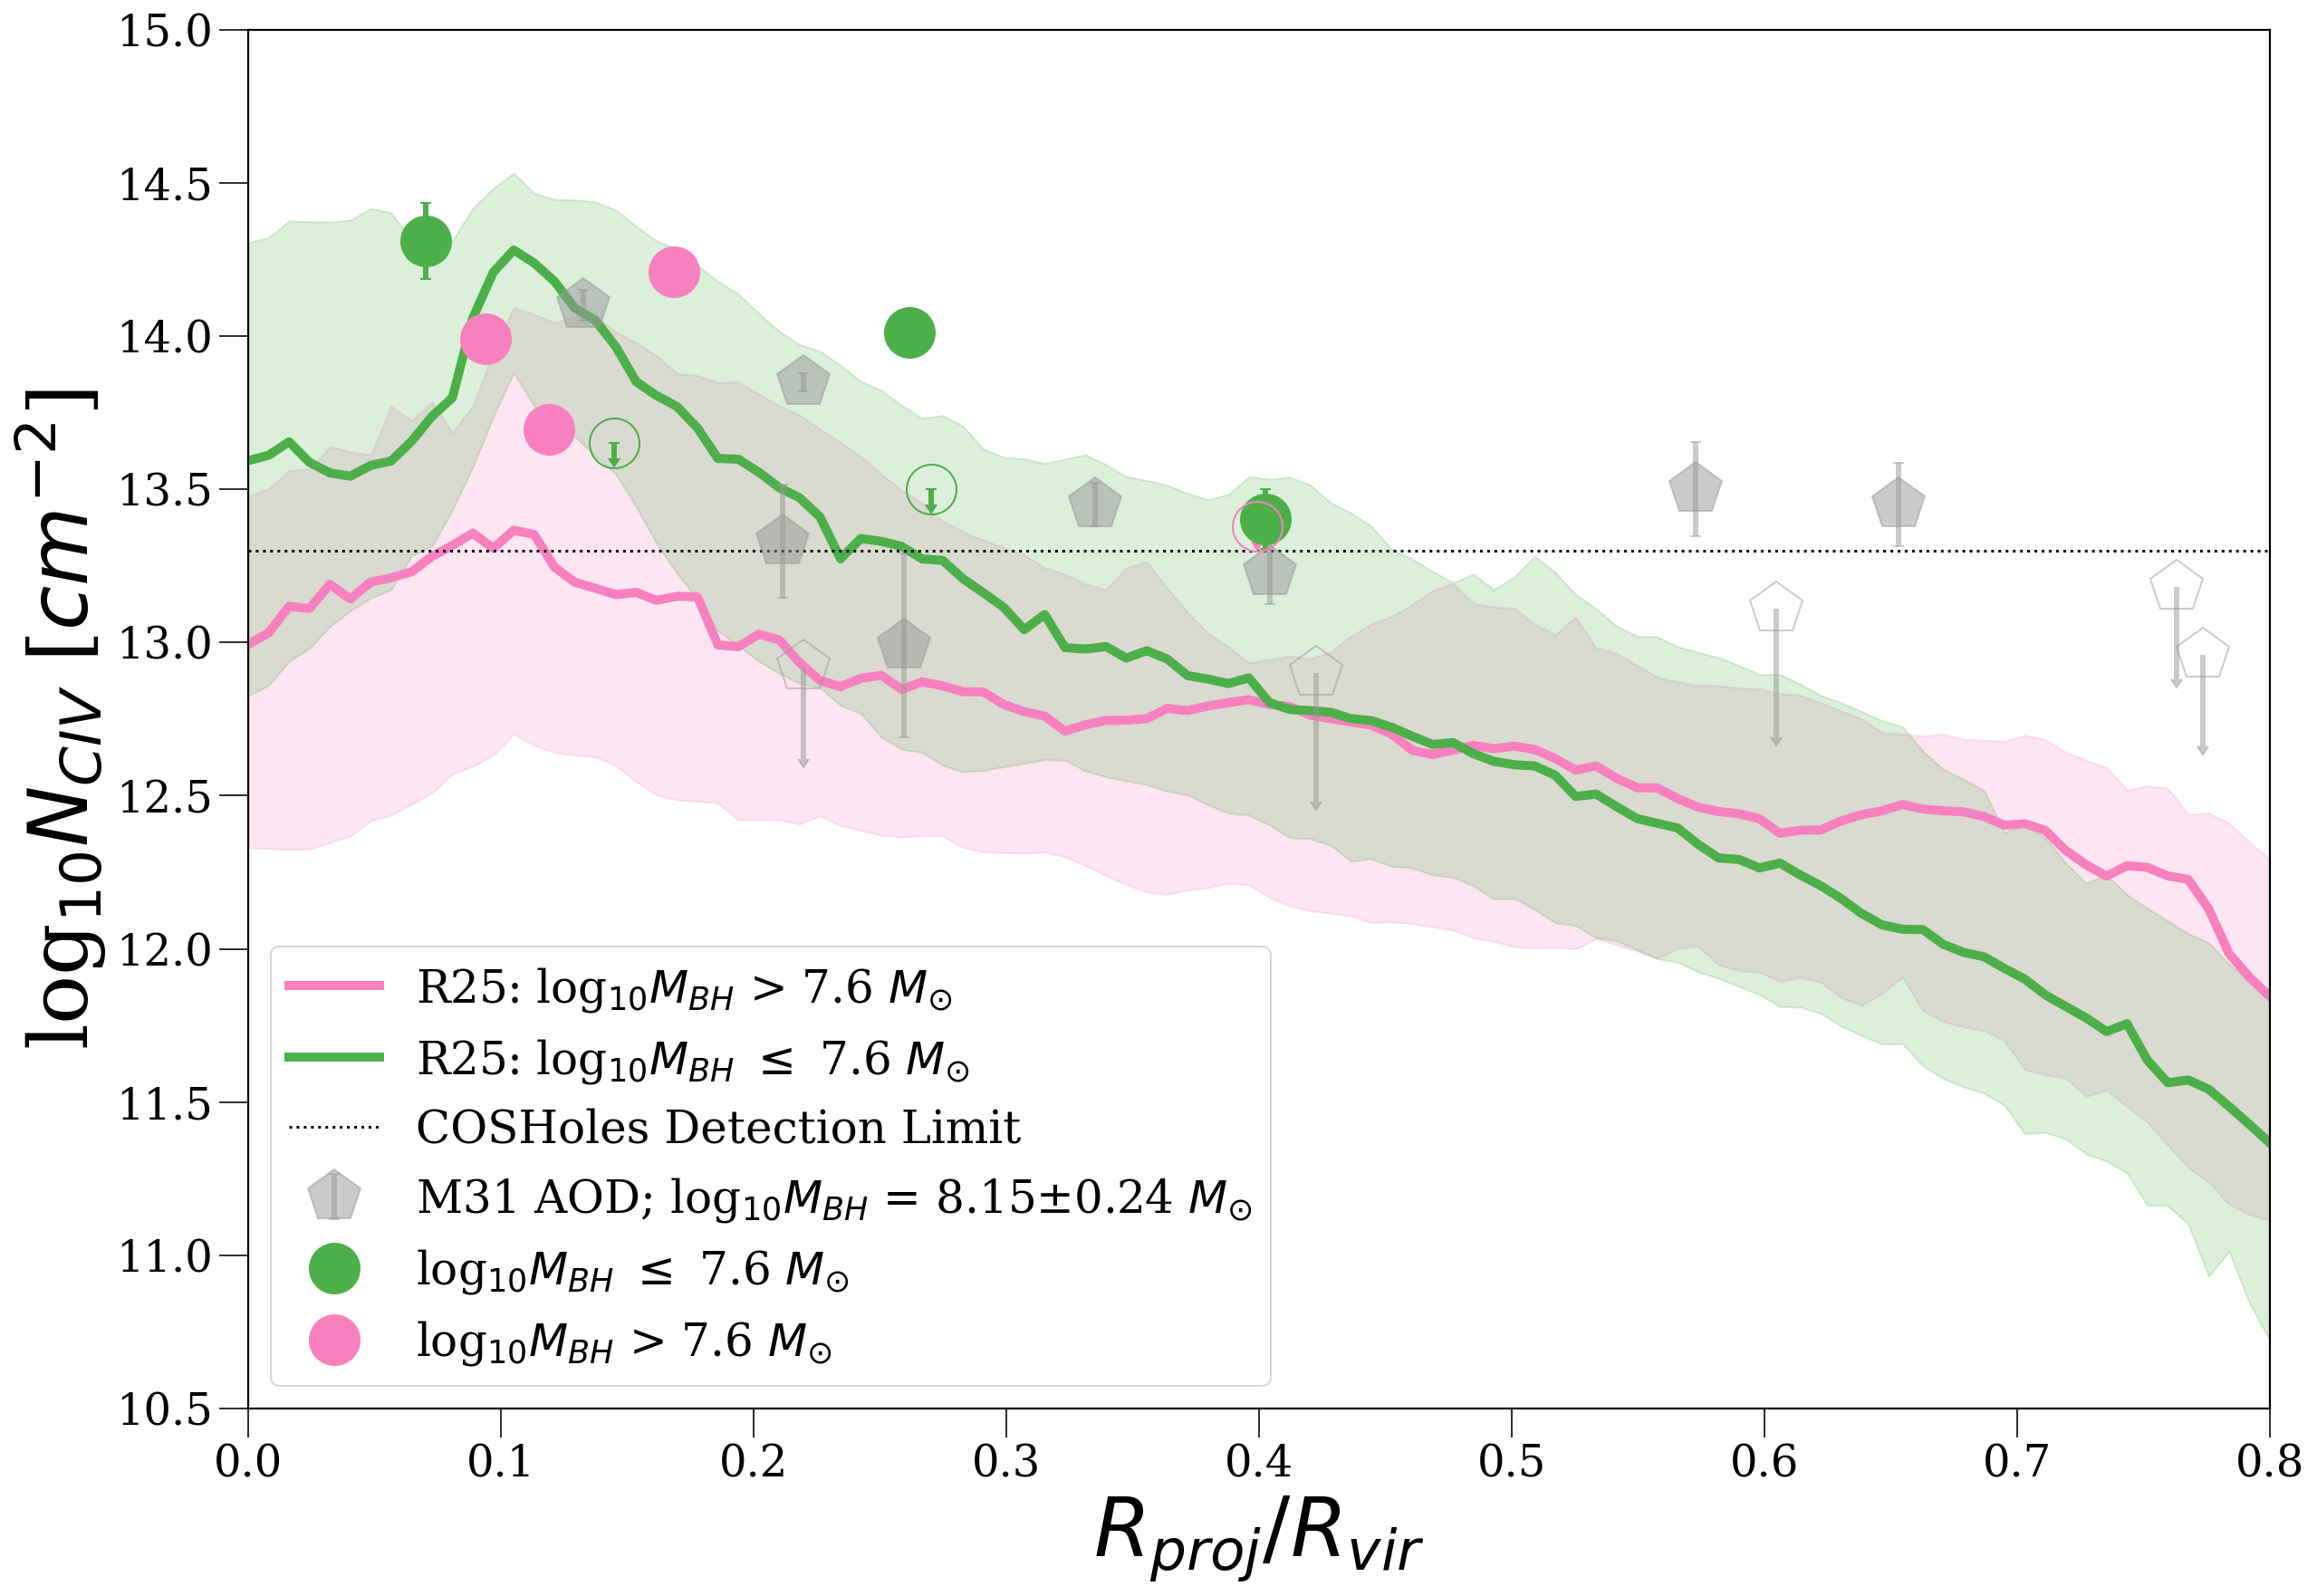

In [22]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#R25

plt.fill_between(r25_rr['Rproj/Rvir'], hmbh_16['16per'], hmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(r25_rr['Rproj/Rvir'], hmbh_civ['logNciv'], c = CB_color_cycle[3], linewidth = 5, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$')
plt.fill_between(r25_rr['Rproj/Rvir'], lmbh_16['16per'], lmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(r25_rr['Rproj/Rvir'], lmbh_civ['logNciv'], c = CB_color_cycle[2], linewidth = 5, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha =0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=3, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(10.5, 15)
ax.set_xlim(0, 0.8)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

## Statistics for the Sims compared to COS-Holes 

### EAGLE

In [23]:
#The actual stats part 

import statistics
import math

#Checking this using the low values because they are closer to the simulation predictions 
def variance(med, data): 
    # Number of observations
    n = len(data)
    
    #mean of the data => using the median values from EAGLE 
    mean = med 
    
    #square deviations
    devs = (data-mean)**2 
    
    #variance
    variance = devs
    return variance  

In [ ]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
eagle_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
             'R': [df_r_new_low['#R(kpc)'][10], df_r_new_high['#R(kpc)'][3], df_r_new_low['#R(kpc)'][2], df_r_new_high['#R(kpc)'][4],
               df_r_new_low['#R(kpc)'][11], df_r_new_high['#R(kpc)'][5]],
         'RR': [df_rr_new_low['#R/R200'][6], df_rr_new_high['#R/R200'][2], df_rr_new_low['#R/R200'][1], df_rr_new_high['#R/R200'][1],
                df_rr_new_low['#R/R200'][4], df_rr_new_high['#R/R200'][2]],
        'medianCIV': [df_r_new_low['median'][10], df_r_new_high['median'][3], df_r_new_low['median'][2], df_r_new_high['median'][4], 
                     df_r_new_high['median'][11], df_r_new_high['median'][5]], 
            'medianCIVRR': [df_rr_new_low['median'][6], df_rr_new_low['median'][2], df_rr_new_low['median'][1], df_rr_new_low['median'][1], 
                           df_rr_new_low['median'][4], df_rr_new_low['median'][2]]}
E_sum = pd.DataFrame(data=eagle_sum)

In [ ]:
#New larger df with Eagle values included 
E_sum_ch = pd.merge(sum_ch, E_sum, on="QSO")
E_sum_ch

In [ ]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

eagle_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'R': [df_r_new_low['#R(kpc)'][6], df_r_new_low['#R(kpc)'][12], df_r_new_high['#R(kpc)'][12]],
         'RR': [df_rr_new_low['#R/R200'][2], df_rr_new_low['#R/R200'][4], df_rr_new_high['#R/R200'][6]],
        'medianCIV': [df_r_new_low['median'][6], df_r_new_low['median'][12], df_r_new_high['median'][12]], 
            'medianCIVRR': [df_rr_new_low['median'][2], df_rr_new_low['median'][4], df_rr_new_high['median'][6]]}
E_up = pd.DataFrame(data=eagle_uplim)

In [ ]:
#New larger df with Eagle values included 
E_up_ch = pd.merge(up_ch, E_up, on="QSO")
E_up_ch

In [ ]:
#Need these things in arrays to make it easier to run through the function 
E_sum_medCIV = np.array(E_sum_ch['medianCIV'])
E_sum_medCIVRR = np.array(E_sum_ch['medianCIVRR'])
sum_civ = np.array(E_sum_ch['N'])

#### SUMMED VALUES (DET)

In [ ]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (E_sum_ch["MBH"] <= 7.6), (E_sum_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_sum_medCIV, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {(std*100)[mask]}')

In [ ]:
#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_sum_medCIVRR, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {(std*100)[mask]}')

#### UPPER LIMITS (NON-DET)

In [ ]:
#Need these things in arrays to make it easier to run through the function 
E_up_medCIV = np.array(E_up_ch['medianCIV'])
E_up_medCIVRR = np.array(E_up_ch['medianCIVRR'])
up_civ = np.array(E_up_ch['N'])

In [ ]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (E_up_ch["MBH"] <= 7.6), (E_up_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_up_medCIV, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {(std*100)[mask]}')

In [ ]:
#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_up_medCIVRR, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {(std*100)[mask]}')

### R25

In [24]:
pd.set_option('display.max_rows', None)

In [25]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the det values 
r25_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
           'RR': [r25_rr['Rproj/Rvir'][50], r25_rr['Rproj/Rvir'][14], r25_rr['Rproj/Rvir'][9], 
                        r25_rr['Rproj/Rvir'][12], r25_rr['Rproj/Rvir'][32], r25_rr['Rproj/Rvir'][21]],
           'medianCIVRR': [lmbh_civ['logNciv'][50], hmbh_civ['logNciv'][14], lmbh_civ['logNciv'][9], 
                        hmbh_civ['logNciv'][12], lmbh_civ['logNciv'][32], hmbh_civ['logNciv'][21]]
          }
R25_sum = pd.DataFrame(data=r25_sum)

In [26]:
#New larger df with R25 values included 
R25_sum_ch = pd.merge(sum_ch, R25_sum, on="QSO")
R25_sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,N,sigN,b,sigb,vel,sigvel,comp,uplim,RR,medianCIVRR
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1,0.404040,12.804102
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1,0.113131,13.352668
2,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1,0.072727,13.738095
3,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1,0.096970,13.307242
4,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1,0.258586,13.313658
5,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1,0.169697,13.150902


In [27]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

r25_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'RR': [r25_rr['Rproj/Rvir'][18], r25_rr['Rproj/Rvir'][34], r25_rr['Rproj/Rvir'][49]],
               'medianCIVRR': [lmbh_civ['logNciv'][18], lmbh_civ['logNciv'][34], hmbh_civ['logNciv'][49]]
            }
R25_up = pd.DataFrame(data=r25_uplim)

In [28]:
#New larger df with R25 values included 
R25_up_ch = pd.merge(up_ch, R25_up, on="QSO")
R25_up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,N,sigN,b,sigb,vel,sigvel,comp,uplim,RR,medianCIVRR
0,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,13.65,0.05,0.0,0.0,0.0,0.0,1,0,0.145455,13.965120
1,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,13.50,0.05,0.0,0.0,0.0,0.0,1,0,0.274747,13.268107
2,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,13.38,0.05,0.0,0.0,0.0,0.0,1,0,0.395960,12.813215


#### SUMMED (DET)

In [29]:
#For the actual stats part 
#Need these things in arrays to make it easier to run through the function 
R25_sum_medCIVRR = np.array(R25_sum_ch['medianCIVRR'])
sum_civ = np.array(R25_sum_ch['N'])

In [30]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (R25_sum_ch["MBH"] <= 7.6), (R25_sum_ch["MBH"] > 7.6)

#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(R25_sum_medCIVRR, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {np.round((std*100)[mask],2)}')

Sigma values for Rproj/Rvir Calculations in Low MBH Sample: [59.89 57.32 69.83]
Sigma values for Rproj/Rvir Calculations in High MBH Sample: [ 34.43  68.28 106.01]


#### UPPER LIMITS (NON-DET)

In [31]:
#Need these things in arrays to make it easier to run through the function 
R25_up_medCIVRR = np.array(R25_up_ch['medianCIVRR'])
up_civ = np.array(R25_up_ch['N'])

In [32]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (R25_up_ch["MBH"] <= 7.6), (R25_up_ch["MBH"] > 7.6)


#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(R25_up_medCIVRR, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {np.round((std*100)[mask], 2)}')

Sigma values for Rproj/Rvir Calculations in Low MBH Sample: [31.51 23.19]
Sigma values for Rproj/Rvir Calculations in High MBH Sample: [56.68]
